In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
df = pd.read_csv(url, names=columns)

# Check first 5 rows
print(df.head())

# Check missing values (if any, replace 0 with NaN for relevant columns)
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[zero_cols] = df[zero_cols].replace(0, np.nan)

# Fill missing values with median
df.fillna(df.median(), inplace=True)

# Check class distribution (imbalance?)
print(df['Outcome'].value_counts())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Outcome
0    500
1    268
Name: count, dtype: int64


In [ ]:
df['BMI_Glucose_Ratio'] = df['BMI'] / df['Glucose']
df['Age_Insulin_Interaction'] = df['Age'] * df['Insulin']

In [ ]:
from scipy import stats

# Remove outliers (Z-score > 3)
z_scores = stats.zscore(df.drop('Outcome', axis=1))
df = df[(np.abs(z_scores) < 3).all(axis=1)]

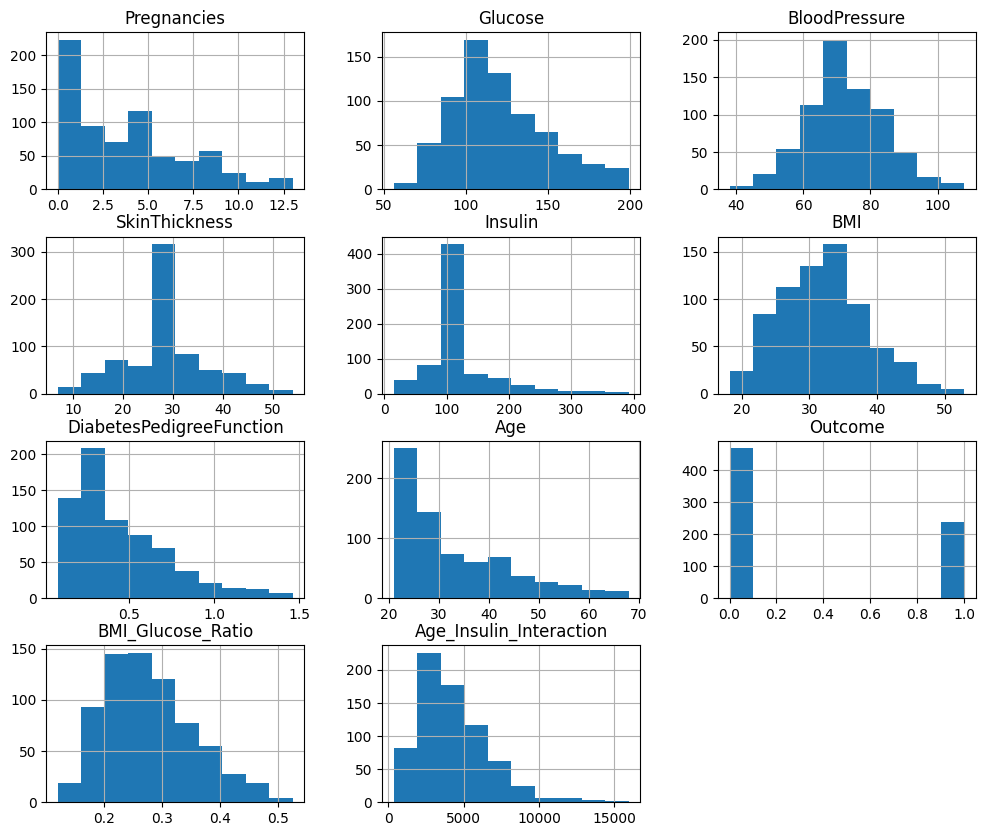

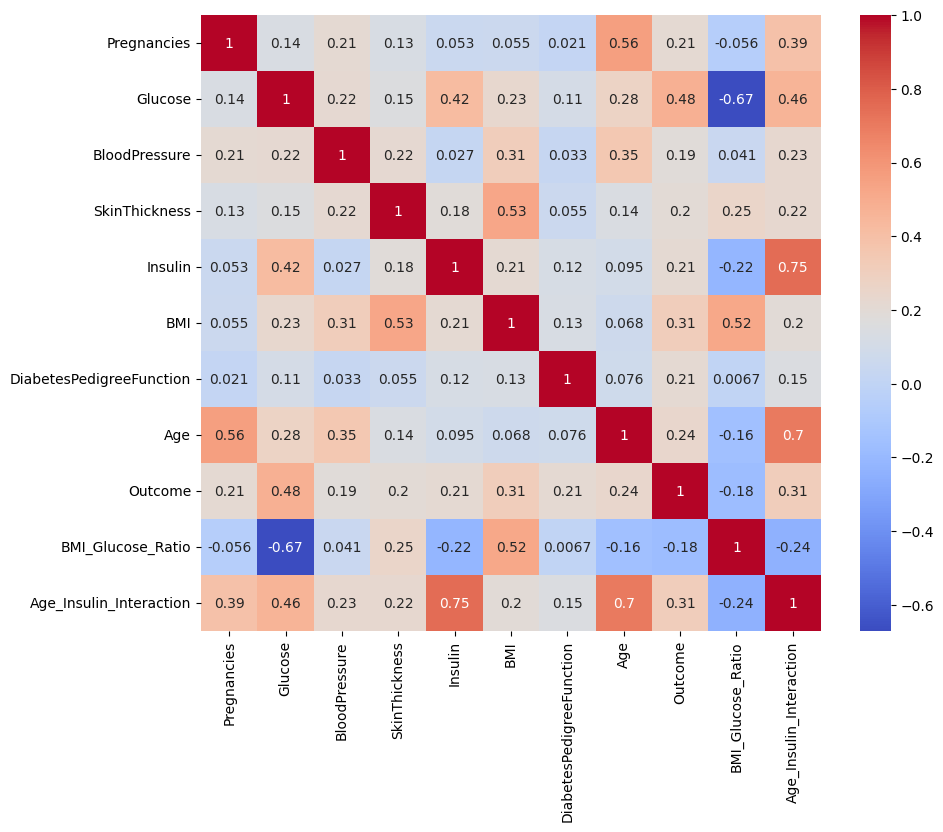

In [ ]:
# Distribution of features
df.hist(figsize=(12, 10))
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

X = df.drop('Outcome', axis=1)
y = df['Outcome']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Feature selection (RFE)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=5)
fit = rfe.fit(X_scaled, y)
selected_features = X.columns[fit.support_]
X_selected = X_scaled[:, fit.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction',
       'BMI_Glucose_Ratio'],
      dtype='object')


In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_selected, y)
print("Resampled class counts:", pd.Series(y_res).value_counts())

Resampled class counts: Outcome
1    468
0    468
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
from sklearn.ensemble import RandomForestClassifier

# Tune Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

In [ ]:
import xgboost as xgb

# Tune XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9]
}
xgb_model = xgb.XGBClassifier(random_state=42)
grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='accuracy')
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_


In [ ]:
# LightGBM
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 375, number of negative: 373
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 748, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501337 -> initscore=0.005348
[LightGBM] [Info] Start training from score 0.005348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LGBMClassifier(random_state=42)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
estimators = [('rf', best_rf), ('xgb', best_xgb)]
stack = StackingClassifier(estimators=estimators, final_estimator=SVC())
stack.fit(X_train, y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=10,
                                                       n_estimators=50,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,...
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))],
                   final_estimator=SVC())

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_xgb, X_res, y_res, cv=10, scoring='accuracy')
print("XGBoost CV Accuracy:", np.mean(scores))

XGBoost CV Accuracy: 0.7875772134522994


In [ ]:
from sklearn.metrics import accuracy_score

models = {
    "Random Forest": best_rf,
    "XGBoost": best_xgb,
    "LightGBM": lgbm,
    "Stacking": stack
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Random Forest Accuracy: 0.83
XGBoost Accuracy: 0.79
LightGBM Accuracy: 0.79
Stacking Accuracy: 0.82


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


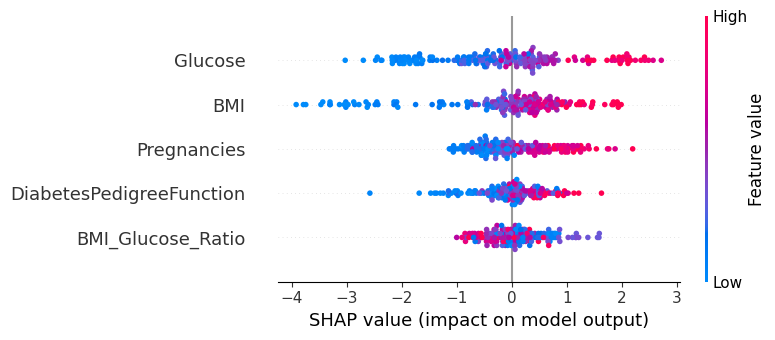

In [ ]:
import shap
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=selected_features)


=== Detailed Performance Metrics ===

**Random Forest**
Accuracy: 0.8298
Precision: 0.7961
Recall: 0.8817
F1-Score: 0.8367
ROC-AUC: 0.9048


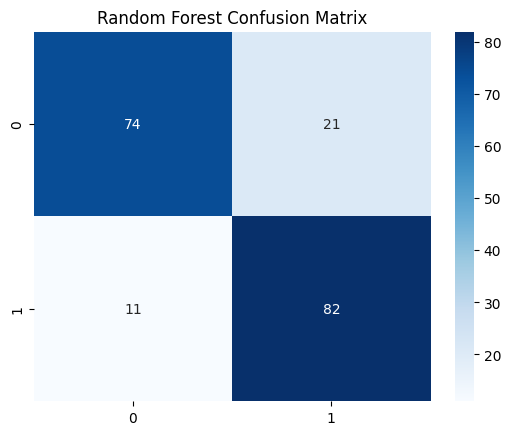

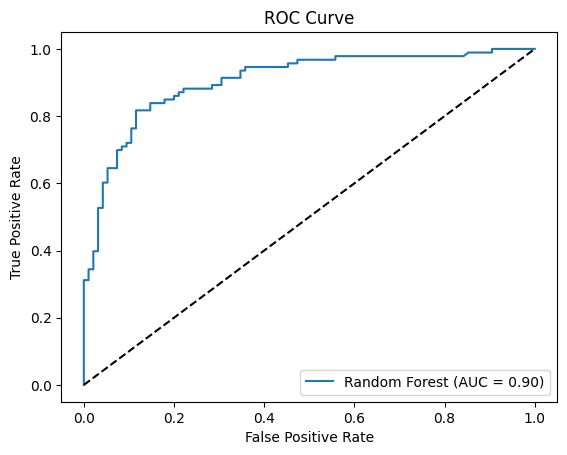


**XGBoost**
Accuracy: 0.7926
Precision: 0.7700
Recall: 0.8280
F1-Score: 0.7979
ROC-AUC: 0.8898


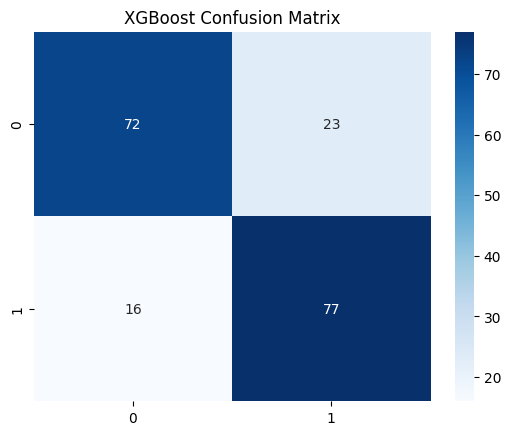

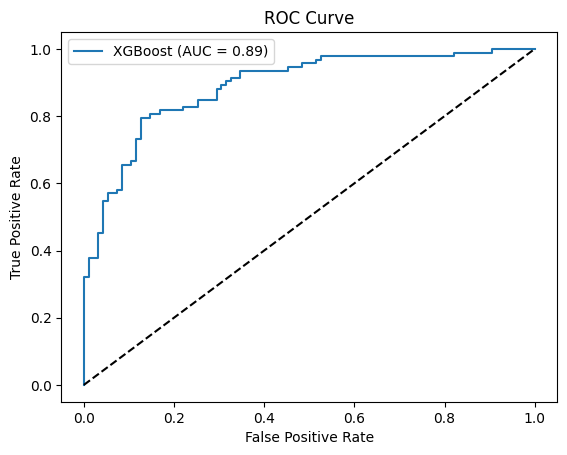


**LightGBM**
Accuracy: 0.7872
Precision: 0.7677
Recall: 0.8172
F1-Score: 0.7917
ROC-AUC: 0.8647


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


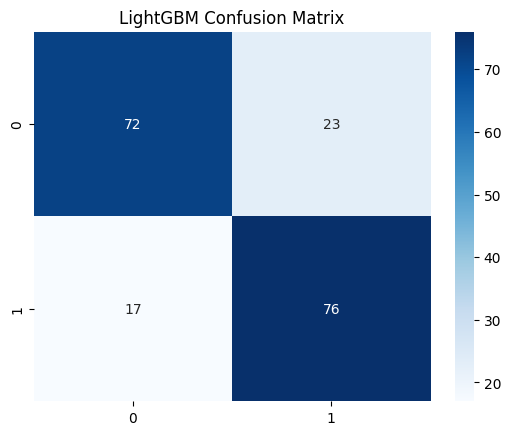

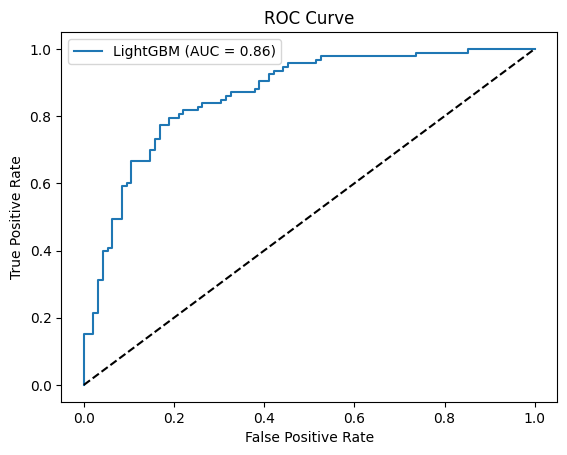


**Stacking**
Accuracy: 0.8245
Precision: 0.7941
Recall: 0.8710
F1-Score: 0.8308
ROC-AUC: 0.5000


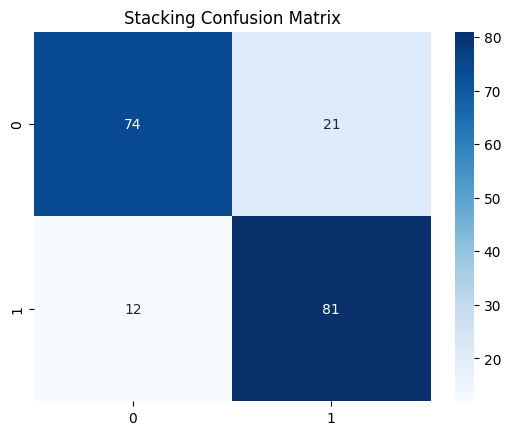

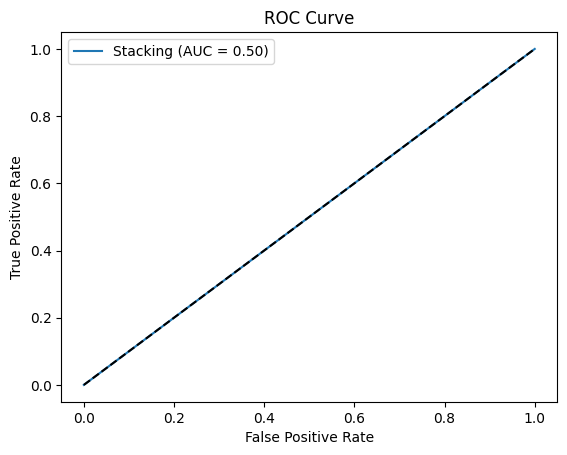

In [ ]:
from sklearn.metrics import (precision_score, recall_score, f1_score,
                            roc_auc_score, confusion_matrix, roc_curve)

# ===== Insert after Step 8's model evaluation loop =====
print("\n=== Detailed Performance Metrics ===")
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else [0]*len(X_test)

    print(f"\n**{name}**")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

In [ ]:
# ===== Insert after the metrics section =====
print("\n=== Subgroup Analysis (Age Groups) ===")

# Create age groups
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 30, 50, 100], labels=['<30', '30-50', '>50'])

# Prepare test set with age groups
X_test_df = pd.DataFrame(X_test, columns=selected_features)

# Find the index of 'Age' within the selected features
try:
    age_col_index_selected = selected_features.get_loc('Age')

    # Find the index of 'Age' within the original 10 features (before selection)
    original_features = df.drop('Outcome', axis=1).columns
    age_col_index_original = original_features.get_loc('Age')

    # Extract the scaled 'Age' column from X_test
    X_test_age_scaled = X_test[:, age_col_index_selected].reshape(-1, 1)

    # Inverse transform only the 'Age' column using the original scaler's parameters for 'Age'
    # We need to manually apply the inverse transformation formula X_original = X_scaled * scale + mean
    # Or, use the scaler's inverse_transform method on a single column
    X_test_age_original = scaler.inverse_transform(np.zeros_like(scaler.mean_).reshape(1, -1))
    X_test_age_original[0, age_col_index_original] = X_test_age_scaled[0] # Placeholder value

    # A more direct way is to apply the formula: original = scaled * scale + mean
    age_mean = scaler.mean_[age_col_index_original]
    age_scale = scaler.scale_[age_col_index_original]
    X_test_df['Age'] = X_test_age_scaled.flatten() * age_scale + age_mean

except KeyError:
    # Handle the case where 'Age' is not among the selected features
    print("Warning: 'Age' not found in selected features. Cannot perform age group analysis.")
    # Skip the rest of the age group analysis or handle as appropriate
    pass


# Only proceed if Age was found and added to X_test_df
if 'Age' in X_test_df.columns:
    X_test_df['Age_Group'] = pd.cut(X_test_df['Age'], bins=[0, 30, 50, 100], labels=['<30', '30-50', '>50'])

    # Evaluate best model (XGBoost) by age group
    for group in ['<30', '30-50', '>50']:
        mask = (X_test_df['Age_Group'] == group)
        if sum(mask) > 0:  # Check if group exists in test set
            # Ensure y_test is a pandas Series to allow boolean indexing with mask
            if not isinstance(y_test, pd.Series):
                y_test_series = pd.Series(y_test, index=X_test_df.index)
            else:
                 y_test_series = y_test

            y_group = y_test_series[mask]

            # Apply the mask to the original X_test numpy array
            X_test_group = X_test[mask.values] # .values is needed for boolean indexing of numpy array

            y_pred_group = best_xgb.predict(X_test_group)
            y_proba_group = best_xgb.predict_proba(X_test_group)[:, 1]

            print(f"\n**Age Group: {group} (n={sum(mask)})**")
            print(f"Accuracy: {accuracy_score(y_group, y_pred_group):.4f}")
            print(f"Precision: {precision_score(y_group, y_pred_group):.4f}")
            print(f"Recall: {recall_score(y_group, y_pred_group):.4f}")
            # Check if there are both positive and negative samples in y_group for ROC-AUC
            if len(np.unique(y_group)) > 1:
                print(f"ROC-AUC: {roc_auc_score(y_group, y_proba_group):.4f}")
            else:
                print("ROC-AUC: N/A (only one class present)")


=== Subgroup Analysis (Age Groups) ===


In [ ]:
# ===== Add Glucose Subgroup Analysis =====
print("\n=== Subgroup Analysis (Glucose Groups) ===")

# Create Glucose groups based on quantiles (or clinical thresholds if preferred)
# Using quantiles to ensure roughly equal group sizes
glucose_bins = df['Glucose'].quantile([0, 0.33, 0.66, 1]).tolist() # Example: Tertiles
glucose_labels = ['Low Glucose', 'Medium Glucose', 'High Glucose']
df['Glucose_Group'] = pd.cut(df['Glucose'], bins=glucose_bins, labels=glucose_labels, include_lowest=True)

# Ensure X_test_df is created if it wasn't already by the Age analysis (e.g., if Age was not selected)
if 'X_test_df' not in locals():
     X_test_df = pd.DataFrame(X_test, columns=selected_features)

# Find the index of 'Glucose' within the selected features
try:
    glucose_col_index_selected = selected_features.get_loc('Glucose')

    # Find the index of 'Glucose' within the original 10 features (before selection)
    original_features = df.drop('Outcome', axis=1).columns
    glucose_col_index_original = original_features.get_loc('Glucose')

    # Extract the scaled 'Glucose' column from X_test
    X_test_glucose_scaled = X_test[:, glucose_col_index_selected].reshape(-1, 1)

    # Apply the inverse transformation formula: original = scaled * scale + mean
    glucose_mean = scaler.mean_[glucose_col_index_original]
    glucose_scale = scaler.scale_[glucose_col_index_original]
    X_test_df['Glucose'] = X_test_glucose_scaled.flatten() * glucose_scale + glucose_mean

except KeyError:
    # Handle the case where 'Glucose' is not among the selected features
    print("Warning: 'Glucose' not found in selected features. Cannot perform glucose group analysis.")
    # Skip the rest of the glucose group analysis
    pass

# Only proceed if Glucose was found and added to X_test_df
if 'Glucose' in X_test_df.columns:
    # Use the same bins/labels as the original df, but apply to the inverse-transformed Glucose in X_test_df
    X_test_df['Glucose_Group'] = pd.cut(X_test_df['Glucose'], bins=glucose_bins, labels=glucose_labels, include_lowest=True)

    # Evaluate best model (XGBoost) by glucose group
    for group in glucose_labels:
        mask = (X_test_df['Glucose_Group'] == group)
        if sum(mask) > 0:  # Check if group exists in test set
            # Ensure y_test is a pandas Series to allow boolean indexing with mask
            if not isinstance(y_test, pd.Series):
                y_test_series = pd.Series(y_test, index=X_test_df.index)
            else:
                 y_test_series = y_test

            y_group = y_test_series[mask]

            # Apply the mask to the original X_test numpy array
            X_test_group = X_test[mask.values] # .values is needed for boolean indexing of numpy array

            y_pred_group = best_xgb.predict(X_test_group)
            # Check if the model has predict_proba before calling it
            y_proba_group = best_xgb.predict_proba(X_test_group)[:, 1] if hasattr(best_xgb, "predict_proba") else np.zeros_like(y_group, dtype=float)

            print(f"\n**Glucose Group: {group} (n={sum(mask)})**")
            print(f"Accuracy: {accuracy_score(y_group, y_pred_group):.4f}")
            print(f"Precision: {precision_score(y_group, y_pred_group):.4f}")
            print(f"Recall: {recall_score(y_group, y_pred_group):.4f}")
            # Check if there are both positive and negative samples in y_group for ROC-AUC
            if len(np.unique(y_group)) > 1 and hasattr(best_xgb, "predict_proba"):
                print(f"ROC-AUC: {roc_auc_score(y_group, y_proba_group):.4f}")
            else:
                print("ROC-AUC: N/A (only one class present or no predict_proba)")


=== Subgroup Analysis (Glucose Groups) ===


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).